In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("Diabetes/Data/Multiclass Diabetes Dataset.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

In [17]:
df.head()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0


In [12]:
df.describe()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.545455,49.522727,5.671515,85.806818,6.862727,4.594394,2.151894,1.182879,2.530871,1.479167,26.626856,1.121212
std,0.498875,10.127301,4.002837,99.400047,2.544604,1.289062,1.265841,0.455591,1.000173,3.099856,5.093652,0.914857
min,0.000000,25.000000,1.100000,6.000000,0.900000,0.000000,0.600000,0.400000,0.300000,0.200000,19.000000,0.000000
25%,0.000000,43.000000,3.600000,46.000000,5.000000,3.875000,1.300000,0.900000,1.800000,0.675000,23.000000,0.000000
50%,1.000000,50.000000,4.700000,61.000000,6.100000,4.500000,1.800000,1.100000,2.500000,0.900000,25.000000,1.000000
75%,1.000000,55.250000,6.100000,82.250000,8.200000,5.300000,2.725000,1.325000,3.200000,1.300000,30.000000,2.000000
max,1.000000,77.000000,26.400000,800.000000,14.600000,9.500000,8.700000,4.000000,5.600000,31.800000,43.250000,2.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  264 non-null    int64  
 1   AGE     264 non-null    int64  
 2   Urea    264 non-null    float64
 3   Cr      264 non-null    int64  
 4   HbA1c   264 non-null    float64
 5   Chol    264 non-null    float64
 6   TG      264 non-null    float64
 7   HDL     264 non-null    float64
 8   LDL     264 non-null    float64
 9   VLDL    264 non-null    float64
 10  BMI     264 non-null    float64
 11  Class   264 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 24.9 KB


In [20]:
df['Class'].value_counts()

Class
2    128
0     96
1     40
Name: count, dtype: int64

In [23]:
df['Class'].value_counts(normalize=True)

Class
2    0.484848
0    0.363636
1    0.151515
Name: proportion, dtype: float64

In [24]:
df.isna().sum()

Gender    0
AGE       0
Urea      0
Cr        0
HbA1c     0
Chol      0
TG        0
HDL       0
LDL       0
VLDL      0
BMI       0
Class     0
dtype: int64

In [27]:
print(df.duplicated().sum())

0


# Feature Analysis

In [29]:
normal_ranges = {
    'Urea': (7, 20),
    'Cr': (0.6, 1.3),
    'HbA1c': (0, 5.7),
    'Chol': (0, 200),
    'TG': (0, 150),
    'HDL': {'male': (40, np.inf), 'female': (50, np.inf)},
    'BMI': (18.5, 24.9)
}

In [30]:
def categorize_features(df):
    df_cat = df.copy()
    df_cat['BMI_Category'] = pd.cut(df['BMI'], 
                                     bins=[0, 18.5, 24.9, 29.9, 100],
                                     labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    df_cat['HbA1c_Category'] = pd.cut(df['HbA1c'],
                                       bins=[0, 5.7, 6.4, 100],
                                       labels=['Normal', 'Prediabetic', 'Diabetic'])
    df_cat['Age_Group'] = pd.cut(df['AGE'],
                                  bins=[0, 30, 45, 60, 100],
                                  labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])
    
    return df_cat

In [31]:
df_cat = categorize_features(df)

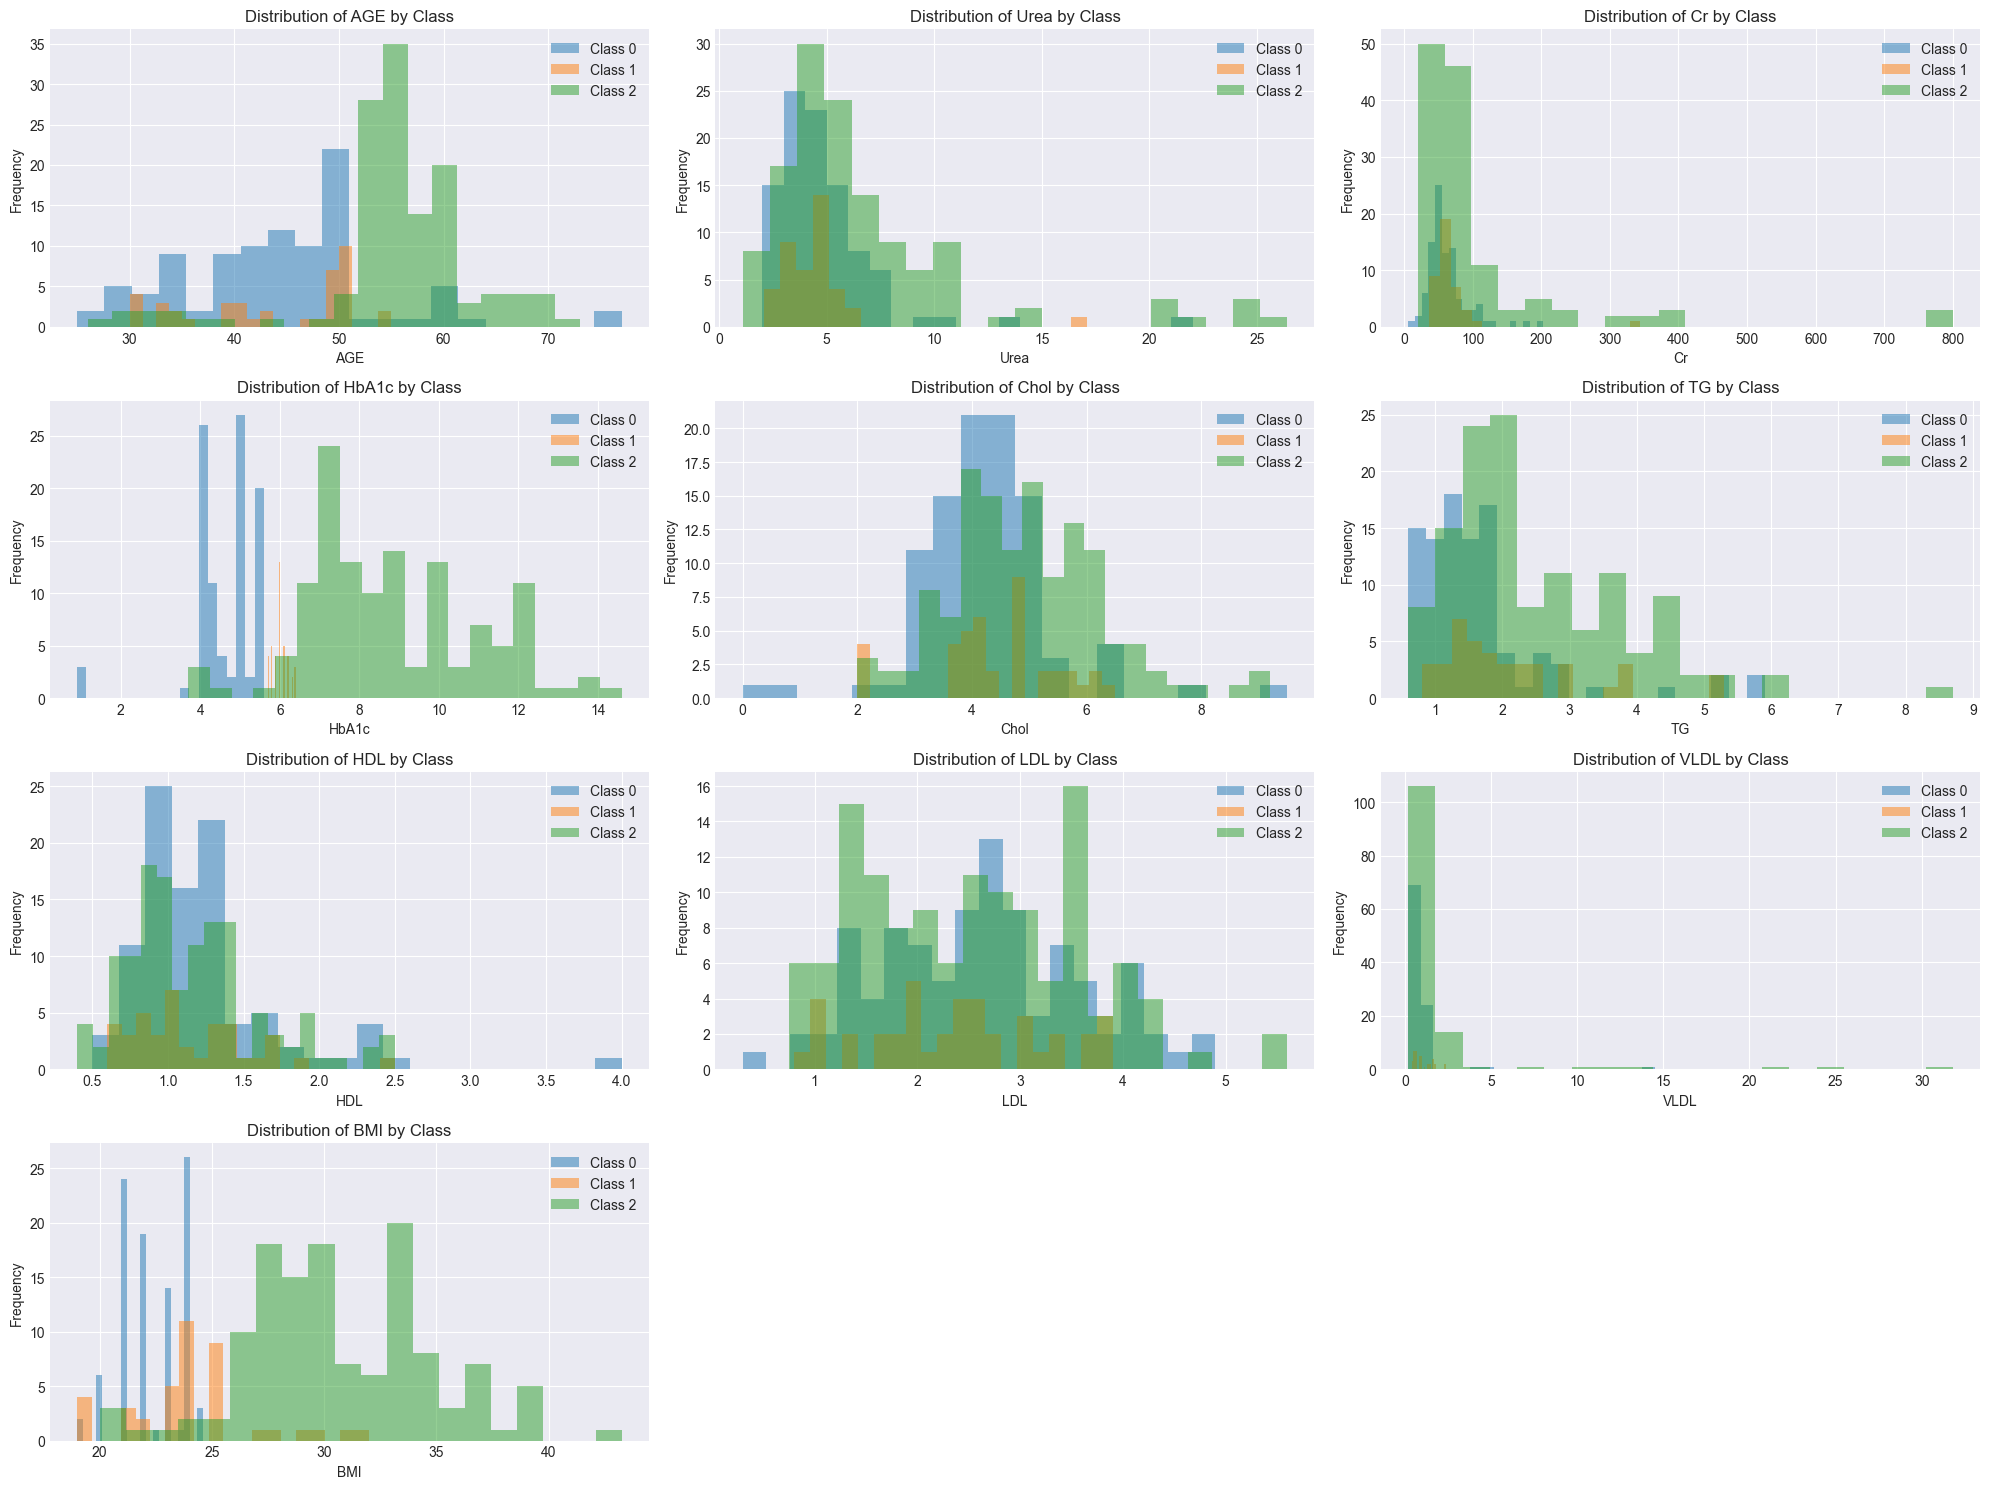

In [34]:
fig = plt.figure(figsize=(20, 15))

continuous_vars = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']

for i, var in enumerate(continuous_vars, 1):
    plt.subplot(4, 3, i)

    for class_val in sorted(df['Class'].unique()):
        data = df[df['Class'] == class_val][var]
        plt.hist(data, alpha=0.5, label=f'Class {class_val}', bins=20)
    
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {var} by Class')
    plt.legend()

plt.tight_layout()
plt.savefig('distributions_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

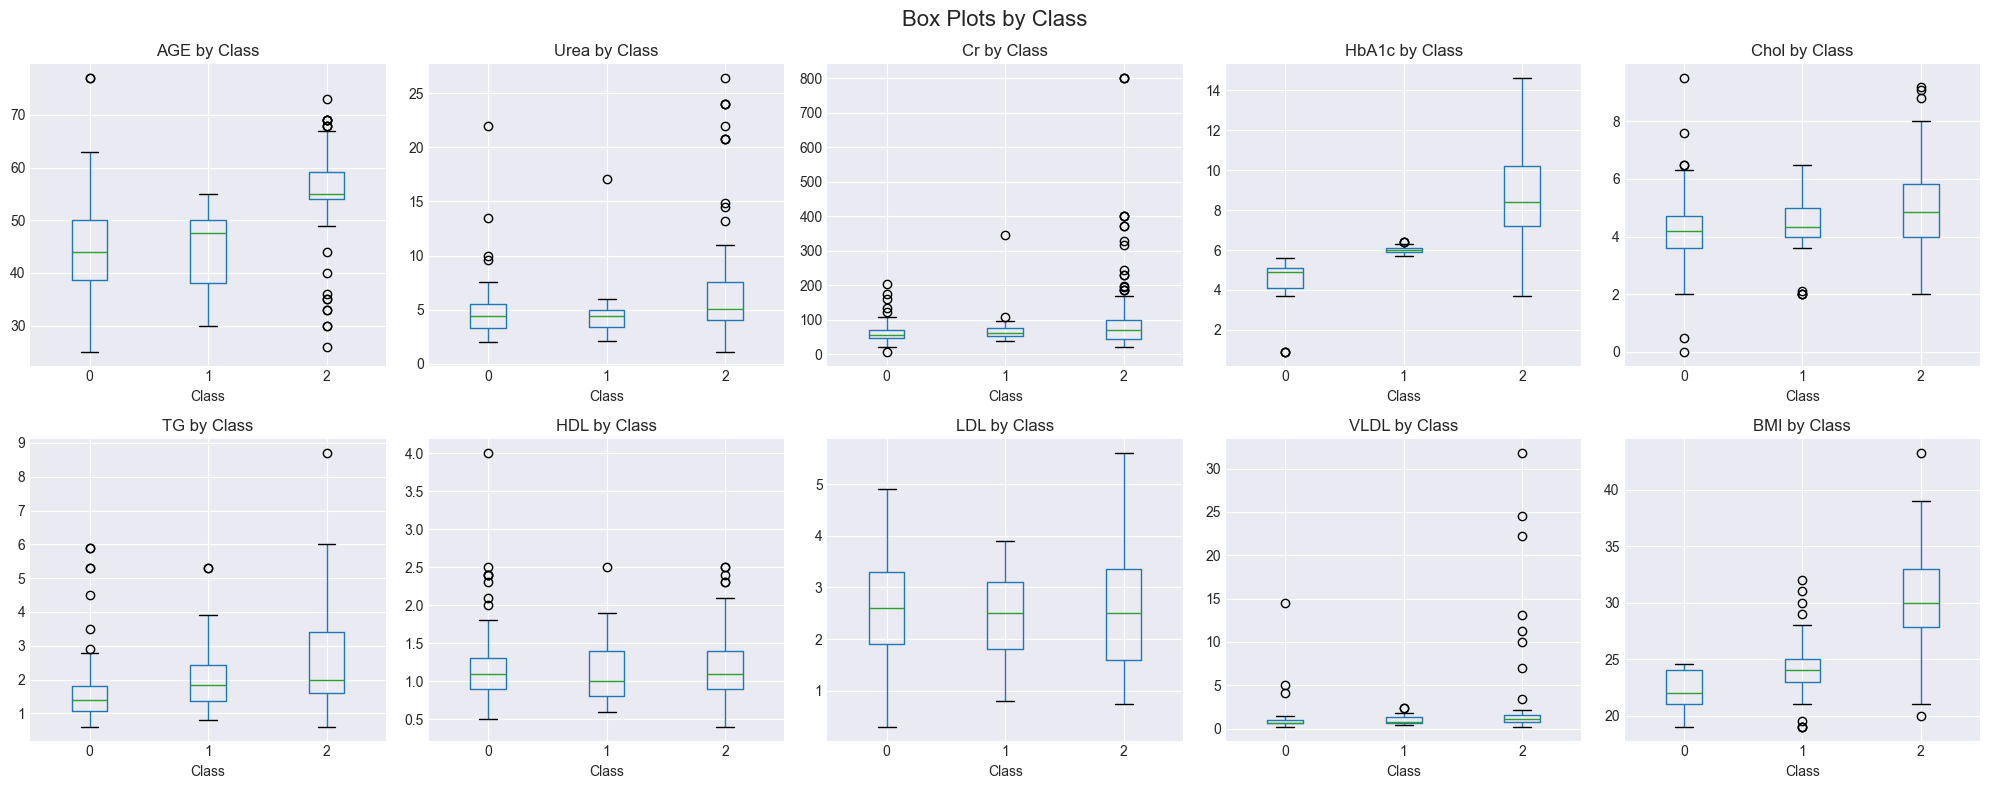

In [36]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, var in enumerate(continuous_vars):
    df.boxplot(column=var, by='Class', ax=axes[i])
    axes[i].set_title(f'{var} by Class')
    axes[i].set_xlabel('Class')

plt.suptitle('Box Plots by Class', fontsize=16)
plt.tight_layout()
plt.savefig('boxplots_by_class.png', dpi=300, bbox_inches='tight')
plt.show()


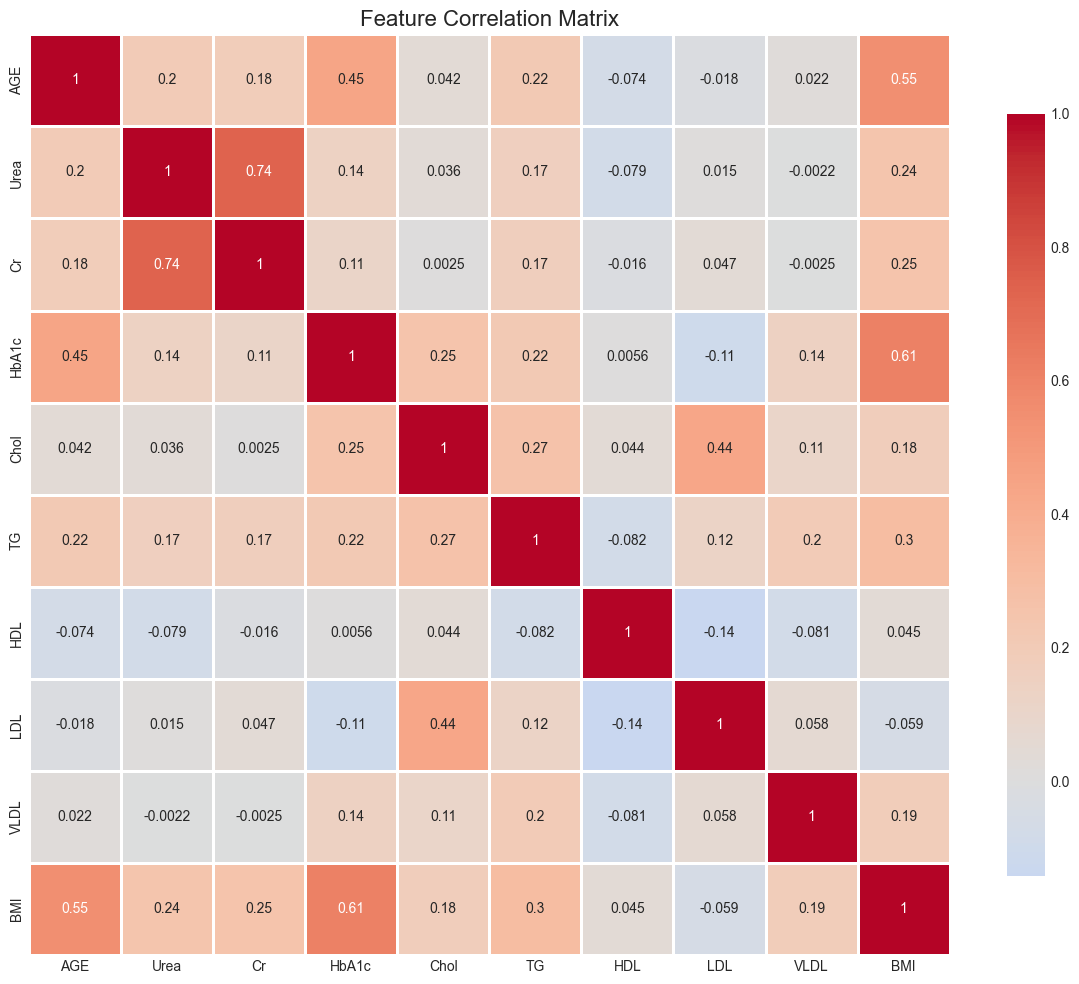

In [37]:
plt.figure(figsize=(12, 10))
correlation_matrix = df[continuous_vars].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1000x600 with 0 Axes>

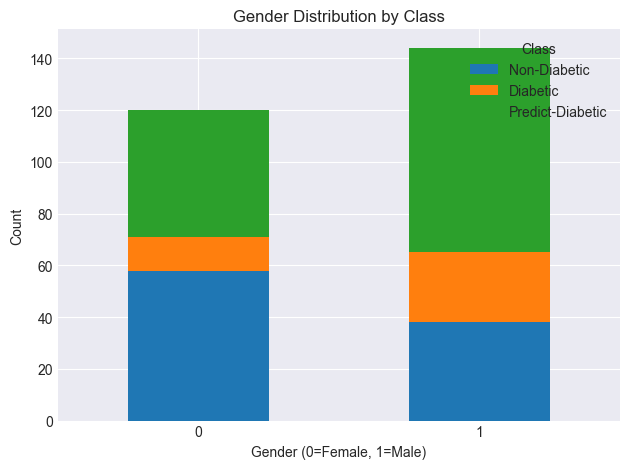

In [39]:
plt.figure(figsize=(10, 6))
gender_class = pd.crosstab(df['Gender'], df['Class'])
gender_class.plot(kind='bar', stacked=True)
plt.title('Gender Distribution by Class')
plt.xlabel('Gender (0=Female, 1=Male)')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Non-Diabetic', 'Diabetic', 'Predict-Diabetic'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('gender_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
print("\nNormality Tests (Shapiro-Wilk):")
for var in continuous_vars:
    stat, p_value = stats.shapiro(df[var].dropna())
    print(f"{var}: Statistic={stat:.4f}, p-value={p_value:.4f}, Normal={'Yes' if p_value > 0.05 else 'No'}")


Normality Tests (Shapiro-Wilk):
AGE: Statistic=0.9701, p-value=0.0000, Normal=No
Urea: Statistic=0.6746, p-value=0.0000, Normal=No
Cr: Statistic=0.4657, p-value=0.0000, Normal=No
HbA1c: Statistic=0.9367, p-value=0.0000, Normal=No
Chol: Statistic=0.9627, p-value=0.0000, Normal=No
TG: Statistic=0.8644, p-value=0.0000, Normal=No
HDL: Statistic=0.8774, p-value=0.0000, Normal=No
LDL: Statistic=0.9813, p-value=0.0015, Normal=No
VLDL: Statistic=0.2735, p-value=0.0000, Normal=No
BMI: Statistic=0.9337, p-value=0.0000, Normal=No


In [42]:
print("\n\nANOVA Tests (relationship with CLASS):")
for var in continuous_vars:
    groups = [group[var].dropna() for name, group in df.groupby('Class')]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"{var}: F-statistic={f_stat:.4f}, p-value={p_value:.4f}, Significant={'Yes' if p_value < 0.05 else 'No'}")




ANOVA Tests (relationship with CLASS):
AGE: F-statistic=60.3677, p-value=0.0000, Significant=Yes
Urea: F-statistic=9.1153, p-value=0.0001, Significant=Yes
Cr: F-statistic=6.4663, p-value=0.0018, Significant=Yes
HbA1c: F-statistic=200.4146, p-value=0.0000, Significant=Yes
Chol: F-statistic=9.8813, p-value=0.0001, Significant=Yes
TG: F-statistic=14.2181, p-value=0.0000, Significant=Yes
HDL: F-statistic=0.4877, p-value=0.6146, Significant=No
LDL: F-statistic=0.9573, p-value=0.3853, Significant=No
VLDL: F-statistic=3.7118, p-value=0.0257, Significant=Yes
BMI: F-statistic=190.5651, p-value=0.0000, Significant=Yes


In [44]:
print("\n\nChi-square test for Gender vs CLASS:")
chi2, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(df['Gender'], df['Class']))
print(f"Chi2 statistic: {chi2:.4f}, p-value: {p_value:.4f}, Significant: {'Yes' if p_value < 0.05 else 'No'}")




Chi-square test for Gender vs CLASS:
Chi2 statistic: 14.0321, p-value: 0.0009, Significant: Yes


In [46]:
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# Prepare data for modeling
X = df.drop(['Class'], axis=1)
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest to get feature importances
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)



=== FEATURE IMPORTANCE ANALYSIS ===


RandomForestClassifier(random_state=42)

In [47]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance)


Feature Importances:
   feature  importance
4    HbA1c    0.422639
10     BMI    0.253901
1      AGE    0.118563
5     Chol    0.037441
2     Urea    0.034825
9     VLDL    0.029822
3       Cr    0.029040
6       TG    0.028039
8      LDL    0.022379
7      HDL    0.018494
0   Gender    0.004858


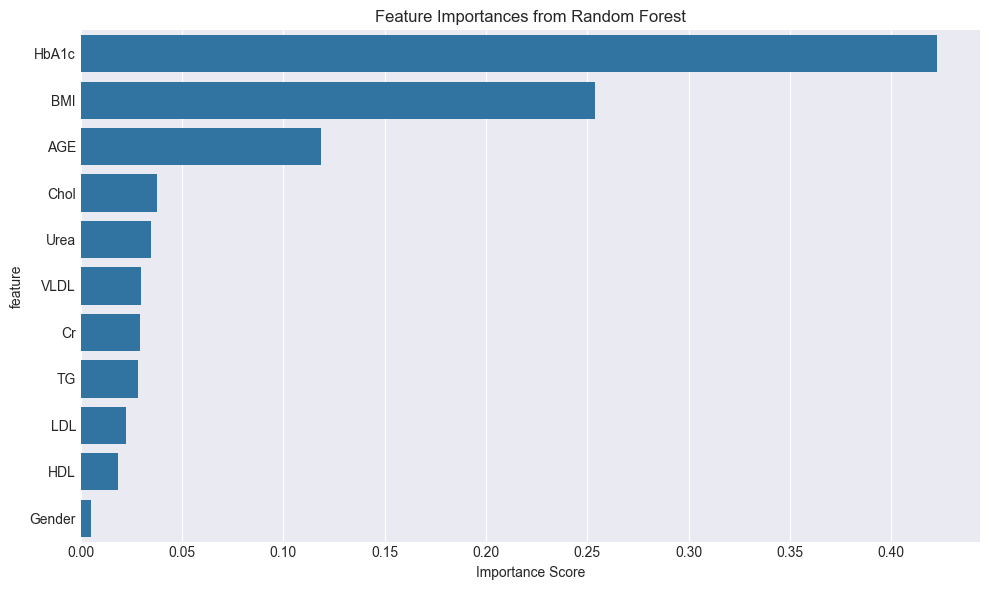

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()



Average Risk Factors by Class:
       High_HbA1c  High_BMI  High_Chol  High_TG  Low_HDL  High_Urea  High_Cr  \
Class                                                                          
0        0.000000  0.000000        0.0      0.0      1.0   0.010417      1.0   
1        0.000000  0.075000        0.0      0.0      1.0   0.000000      1.0   
2        0.929688  0.585938        0.0      0.0      1.0   0.062500      1.0   

       Age_Risk  Total_Risk_Score  
Class                              
0      0.489583               2.5  
1      0.525000               2.6  
2      0.921875               4.5  


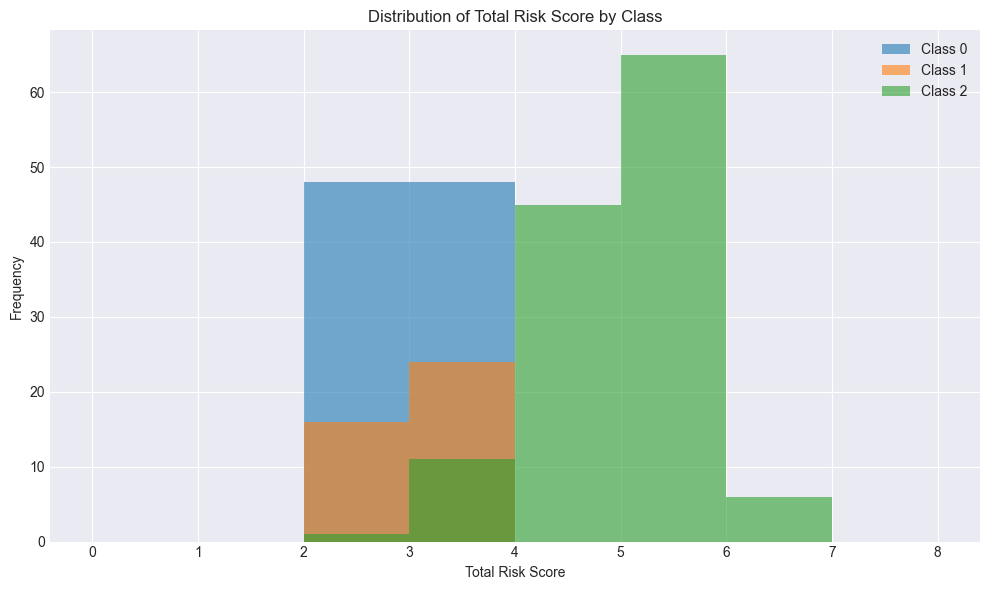

In [51]:
def create_risk_flags(df):
    risk_df = df.copy()
    
    # High risk indicators
    risk_df['High_HbA1c'] = (df['HbA1c'] >= 6.5).astype(int)
    risk_df['High_BMI'] = (df['BMI'] >= 30).astype(int)
    risk_df['High_Chol'] = (df['Chol'] > 200).astype(int)
    risk_df['High_TG'] = (df['TG'] > 150).astype(int)
    risk_df['Low_HDL'] = ((df['Gender'] == 1) & (df['HDL'] < 40) | 
                          (df['Gender'] == 0) & (df['HDL'] < 50)).astype(int)
    risk_df['High_Urea'] = (df['Urea'] > 20).astype(int)
    risk_df['High_Cr'] = (df['Cr'] > 1.3).astype(int)
    risk_df['Age_Risk'] = (df['AGE'] >= 45).astype(int)
    
    # Total risk score
    risk_columns = ['High_HbA1c', 'High_BMI', 'High_Chol', 'High_TG', 
                    'Low_HDL', 'High_Urea', 'High_Cr', 'Age_Risk']
    risk_df['Total_Risk_Score'] = risk_df[risk_columns].sum(axis=1)
    
    return risk_df, risk_columns

risk_df, risk_columns = create_risk_flags(df)

# Analyze risk factors by class
print("\nAverage Risk Factors by Class:")
risk_summary = risk_df.groupby('Class')[risk_columns + ['Total_Risk_Score']].mean()
print(risk_summary)

# Visualize risk score distribution
plt.figure(figsize=(10, 6))
for class_val in sorted(df['Class'].unique()):
    data = risk_df[risk_df['Class'] == class_val]['Total_Risk_Score']
    plt.hist(data, alpha=0.6, label=f'Class {class_val}', bins=range(0, 9))

plt.xlabel('Total Risk Score')
plt.ylabel('Frequency')
plt.title('Distribution of Total Risk Score by Class')
plt.legend()
plt.tight_layout()
plt.savefig('risk_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
print("\n=== SUMMARY REPORT ===")
print("\n1. Dataset Overview:")
print(f"   - Total samples: {len(df)}")
print(f"   - Features: {len(df.columns) - 1}")
print(f"   - Target classes: {df['Class'].nunique()}")
print(f"   - Class distribution: {dict(df['Class'].value_counts())}")

print("\n2. Key Findings:")
print("   - Most important features (top 3):")
for i, row in feature_importance.head(3).iterrows():
    print(f"     * {row['feature']}: {row['importance']:.3f}")

print("\n3. Risk Factor Analysis:")
print(f"   - Average risk score by class:")
for class_val, score in risk_df.groupby('Class')['Total_Risk_Score'].mean().items():
    print(f"     * Class {class_val}: {score:.2f}")

print("\n4. Data Quality:")
print(f"   - Missing values: {df.isnull().sum().sum()}")
print(f"   - Duplicate rows: {df.duplicated().sum()}")



=== SUMMARY REPORT ===

1. Dataset Overview:
   - Total samples: 264
   - Features: 11
   - Target classes: 3
   - Class distribution: {2: np.int64(128), 0: np.int64(96), 1: np.int64(40)}

2. Key Findings:
   - Most important features (top 3):
     * HbA1c: 0.423
     * BMI: 0.254
     * AGE: 0.119

3. Risk Factor Analysis:
   - Average risk score by class:
     * Class 0: 2.50
     * Class 1: 2.60
     * Class 2: 4.50

4. Data Quality:
   - Missing values: 0
   - Duplicate rows: 0
